In [1]:
import os
from os.path import join as opj
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.decomposition import PCA
import SimpleITK as sitk
from radiomics import featureextractor
import statannot

In [2]:
def lineplot_org_sizes(df, size_col = 'organoid_size_pixel', 
                       filename='ground_truth_organoid_sizes_over_time.png', 
                       title='Ground truth organoid sizes',
                       y_label = 'Organoid size in pixel',
                       day_col = 'day_int',
                       ax=None,
                       ylim=None,
                       hue='clone'):
    if ax is None:
        sns.lineplot(data=df.sort_values(day_col), x=day_col, y=size_col, hue=hue)
        sns.despine()
        plt.ylabel(y_label)
        plt.xlabel('Day')
        plt.title(title)
        plt.grid()
        plt.savefig(filename, dpi=200)

    else:
        sns.lineplot(data=df.sort_values(day_col), x=day_col, y=size_col, hue=hue, ax=ax)
        sns.despine()
        ax.set_ylabel(y_label)
        ax.set_xlabel('Day')
        if ylim is not None:
            ax.set_ylim(ylim)
        ax.set_title(title)
    plt.tight_layout()
    
        
def get_dice(pred, true, k=1):
    intersection = np.sum(pred[true == k]) * 2.0
    dice = intersection / (np.sum(pred) + np.sum(true))
    return dice

def get_dice_by_files(gt_file, pred_file):
    if pred_file.endswith('.npy'):
        pred = np.load(pred_file)
    elif pred_file.endswith('.tif') or pred_file.endswith('.tiff'):
        if 'classifier' in pred_file:
            pred = np.asarray(Image.open(pred_file))
            pred = np.where(pred==2, 0, pred)
        elif ('organoseg' in pred_file) or ('cellprofiler' in pred_file):
            pred = np.asarray(Image.open(pred_file))
            pred = np.where(pred>0, 1, 0)
        else:
            pred = np.asarray(Image.open(pred_file))
    else:
        raise NotImplemented
    gt = np.load(gt_file)
    gt = np.where(gt>0, 1, 0)
    dice = get_dice(pred, gt)
    return dice

# Create dataframe

In [3]:
def get_fileending(lab):
    fileending = '.jpg' if lab == 'LabA' else '.tif'
    return fileending

df = pd.read_csv('data/dataset_overview.csv')

img_dir = 'data/imgs'
label_dir = 'data/labels'

x5_ratio_labA = (500/158)**2 # 500 mikrometer are 158 px for magnification 5x -> **2 to adjust for area
x5_ratio_labB = (500/167)**2 # 1
px_mikrometer_ratio = pd.DataFrame.from_dict({'Imaging':['LabA', 'LabB'], 'px_mikrometer_ratio':[x5_ratio_labA, x5_ratio_labB]})
df = df.merge(px_mikrometer_ratio, on='Imaging')

df['img'] = df.apply(lambda row: opj(img_dir, row['img_id'] + get_fileending(row['Imaging'])), axis=1)
df['mask'] = df['img_id'].apply(lambda x: opj(label_dir, f'{x}.npy'))
df

,org_id,img_id,Day,Clone,Imaging,org_size_px2,org_size_mikrometer2,px_mikrometer_ratio,img,mask
0,1,org01_wt2D_d02_LabA,2,wt2D,LabA,34246,342954,10.014421,data/imgs/org01_wt2D_d02_LabA.jpg,data/labels/org01_wt2D_d02_LabA.npy
1,1,org01_wt2D_d05_LabA,5,wt2D,LabA,121634,1218094,10.014421,data/imgs/org01_wt2D_d05_LabA.jpg,data/labels/org01_wt2D_d05_LabA.npy
2,1,org01_wt2D_d08_LabA,8,wt2D,LabA,97399,975395,10.014421,data/imgs/org01_wt2D_d08_LabA.jpg,data/labels/org01_wt2D_d08_LabA.npy
3,1,org01_wt2D_d10_LabA,10,wt2D,LabA,97286,974263,10.014421,data/imgs/org01_wt2D_d10_LabA.jpg,data/labels/org01_wt2D_d10_LabA.npy
4,1,org01_wt2D_d12_LabA_after_embedding,12,wt2D,LabA,64262,643547,10.014421,data/imgs/org01_wt2D_d12_LabA_after_embedding.jpg,data/labels/org01_wt2D_d12_LabA_after_embeddin...
...,...,...,...,...,...,...,...,...,...,...
1402,64,org64_B2A-2_d16_LabB,16,B2A-2,LabB,69942,626968,8.964108,data/imgs/org64_B2A-2_d16_LabB.tif,data/labels/org64_B2A-2_d16_LabB.npy
1403,64,org64_B2A-2_d19_LabB,19,B2A-2,LabB,106752,956936,8.964108,data/imgs/org64_B2A-2_d19_LabB.tif,data/labels/org64_B2A-2_d19_LabB.npy
1404,64,org64_B2A-2_d22_LabB,22,B2A-2,LabB,181577,1627676,8.964108,data/imgs/org64_B2A-2_d22_LabB.tif,data/labels/org64_B2A-2_d22_LabB.npy
1405,64,org64_B2A-2_d25_LabB,25,B2A-2,LabB,214970,1927014,8.964108,data/imgs/org64_B2A-2_d25_LabB.tif,data/labels/org64_B2A-2_d25_LabB.npy


### Plot example segmentation

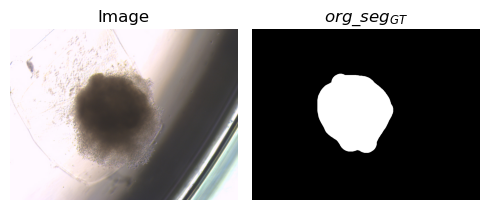

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(5, 5), facecolor='white')

axs[0].imshow(Image.open(df.iloc[30]['img']))
axs[1].imshow(np.load(df.iloc[30]['mask']), cmap='Greys_r')
img_id = df.iloc[2]['img_id']
for i in range(2):
    axs[i].axis('off')
    
axs[0].set_title('Image')
axs[1].set_title(r'$org\_seg_{GT}$')
plt.tight_layout()
# plt.savefig('plots/example_gt_segmentation.png', dpi=300, bbox_inches='tight')
plt.savefig('plots/example_gt_segmentation.svg', bbox_inches='tight')

### Calculate Dice scores for all models

In [5]:
recalculate_dice_scores = False

inf_dirs = ['model_predictions/cellprofiler',
            'model_predictions/organoseg',
            'model_predictions/morgana/LR',
            'model_predictions/morgana/LR',
            'model_predictions/morgana/MLP',
            'model_predictions/morgana/MLP',
            'model_predictions/segformer']
model_names = ['CellProfiler', 'OrganoSeg', 'MOrgAna_LR_C', 'MOrgAna_LR_W', 'MOrgAna_MLP_C', 'MOrgAna_MLP_W', 'SegFormer']
endswiths = ['_finalMask.tiff', '.tif', '_classifier.tif', '_watershed.tif', '_classifier.tif', '_watershed.tif', '.npy']
pred_cols = [f'pred_{mn}' for mn in model_names]

if recalculate_dice_scores:
    
    df_pred = df.copy()
    i = 0
    # calculate predicted organoid sizes
    for inf_dir, model_name in zip(inf_dirs, model_names):
        endswith = endswiths[i]
        df_inf = pd.DataFrame.from_dict({'img_id': [x.replace(endswith, '') for x in os.listdir(inf_dir) if x.endswith(endswith)],
                                                     f'pred_{model_name}': [opj(inf_dir, x) for x in os.listdir(inf_dir) if x.endswith(endswith)]})
        if endswith == '.npy':
            df_inf[f'pred_{model_name}_org_size'] = df_inf[f'pred_{model_name}'].apply(lambda x: np.count_nonzero(np.load(x)))
        elif endswith == '_watershed.tif':
            df_inf[f'pred_{model_name}_org_size'] = df_inf[f'pred_{model_name}'].apply(lambda x: np.count_nonzero(np.asarray(Image.open(x))))
        elif endswith == '_classifier.tif':
            df_inf[f'pred_{model_name}_org_size'] = df_inf[f'pred_{model_name}'].apply(lambda x: np.count_nonzero(np.asarray(Image.open(x))))
        else:
            df_inf[f'pred_{model_name}_org_size'] = df_inf[f'pred_{model_name}'].apply(lambda x: np.count_nonzero(np.asarray(Image.open(x))))
        df_pred = df_pred.merge(df_inf, on='img_id')
        df_pred[f'pred_{model_name}_org_size_mum2'] = df_pred.apply(lambda x: (x[f'pred_{model_name}_org_size']*x['px_mikrometer_ratio']), axis=1)
        df_pred[f'pred_{model_name}_org_size_mm2'] = df_pred[f'pred_{model_name}_org_size_mum2'].apply(lambda x: x/10**6)
        i += 1
    
    # calculate Dice scores
    for pred_col in pred_cols:
        print(pred_col)
        df_pred[pred_col+'_dice'] = df_pred.apply(lambda x: get_dice_by_files(x['mask'], x[pred_col]), axis=1)
    df_pred.to_csv('df_pred.csv', index = False)
else:
    df_pred = pd.read_csv('df_pred.csv')
    
df_pred.shape

(1407, 45)

### Plot Dice scores

/home/ws/oc9627/anaconda3/envs/rob_monit_org_growth/lib/python3.9/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/home/ws/oc9627/anaconda3/envs/rob_monit_org_growth/lib/python3.9/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


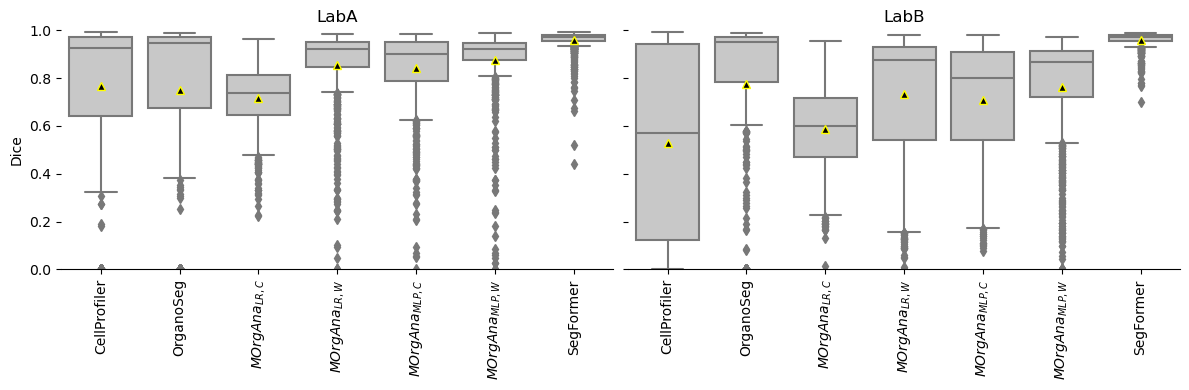

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), facecolor='white', sharey=True)
sns.set_style('whitegrid')
palette = ['#C8C8C8']*7

for i, lab in enumerate(['LabA', 'LabB']): 
    keep_cols = ['img_id'] + [f'{pc}_dice' for pc in pred_cols]
    d = df_pred[df_pred['Imaging'] == lab]
    d = d[keep_cols]
    
    mean_props = {'markerfacecolor': 'black', 'markeredgecolor': 'yellow'}
    sns.boxplot(data=d.rename(columns={'pred_CellProfiler_dice': 'CellProfiler',
                                        'pred_OrganoSeg_dice': 'OrganoSeg',
                                        'pred_MOrgAna_LR_C_dice': r'$MOrgAna_{LR, C}$',
                                        'pred_MOrgAna_LR_W_dice': r'$MOrgAna_{LR, W}$',
                                        'pred_MOrgAna_MLP_C_dice': r'$MOrgAna_{MLP, C}$',
                                        'pred_MOrgAna_MLP_W_dice': r'$MOrgAna_{MLP, W}$',
                                        'pred_SegFormer_dice': 'SegFormer'}), showmeans=True,
               meanprops=mean_props, whis=1.0, palette=palette, ax=axs[i])
    axs[i].set_title(lab)
    axs[0].set_ylabel('Dice')

    axs[i].set_ylim((0, 1))
    axs[i].tick_params(axis='x', rotation = 90)

sns.despine(top=True, left=True)
plt.tight_layout()
plt.savefig(f'plots/dice_score_distribution.svg')

##### Mean and SD of Dice scores

In [7]:
pd.options.display.float_format = '{:.2f}'.format

x = df_pred[df_pred['Imaging']=='LabA']
x[[f'{pc}_dice' for pc in pred_cols]].mean()

pred_CellProfiler_dice    0.77
pred_OrganoSeg_dice       0.75
pred_MOrgAna_LR_C_dice    0.72
pred_MOrgAna_LR_W_dice    0.86
pred_MOrgAna_MLP_C_dice   0.84
pred_MOrgAna_MLP_W_dice   0.88
pred_SegFormer_dice       0.96
dtype: float64

In [8]:
pd.options.display.float_format = '{:.2f}'.format

x = df_pred[df_pred['Imaging']=='LabB']
x[[f'{pc}_dice' for pc in pred_cols]].mean()

pred_CellProfiler_dice    0.53
pred_OrganoSeg_dice       0.77
pred_MOrgAna_LR_C_dice    0.59
pred_MOrgAna_LR_W_dice    0.73
pred_MOrgAna_MLP_C_dice   0.71
pred_MOrgAna_MLP_W_dice   0.76
pred_SegFormer_dice       0.96
dtype: float64

In [9]:
pd.options.display.float_format = '{:.2f}'.format

x = df_pred[df_pred['Imaging']=='LabA']
x[[f'{pc}_dice' for pc in pred_cols]].std()

pred_CellProfiler_dice    0.30
pred_OrganoSeg_dice       0.36
pred_MOrgAna_LR_C_dice    0.13
pred_MOrgAna_LR_W_dice    0.17
pred_MOrgAna_MLP_C_dice   0.16
pred_MOrgAna_MLP_W_dice   0.15
pred_SegFormer_dice       0.05
dtype: float64

In [10]:
pd.options.display.float_format = '{:.2f}'.format

x = df_pred[df_pred['Imaging']=='LabB']
x[[f'{pc}_dice' for pc in pred_cols]].std()

pred_CellProfiler_dice    0.39
pred_OrganoSeg_dice       0.34
pred_MOrgAna_LR_C_dice    0.17
pred_MOrgAna_LR_W_dice    0.27
pred_MOrgAna_MLP_C_dice   0.24
pred_MOrgAna_MLP_W_dice   0.24
pred_SegFormer_dice       0.03
dtype: float64

### Per day dice scores

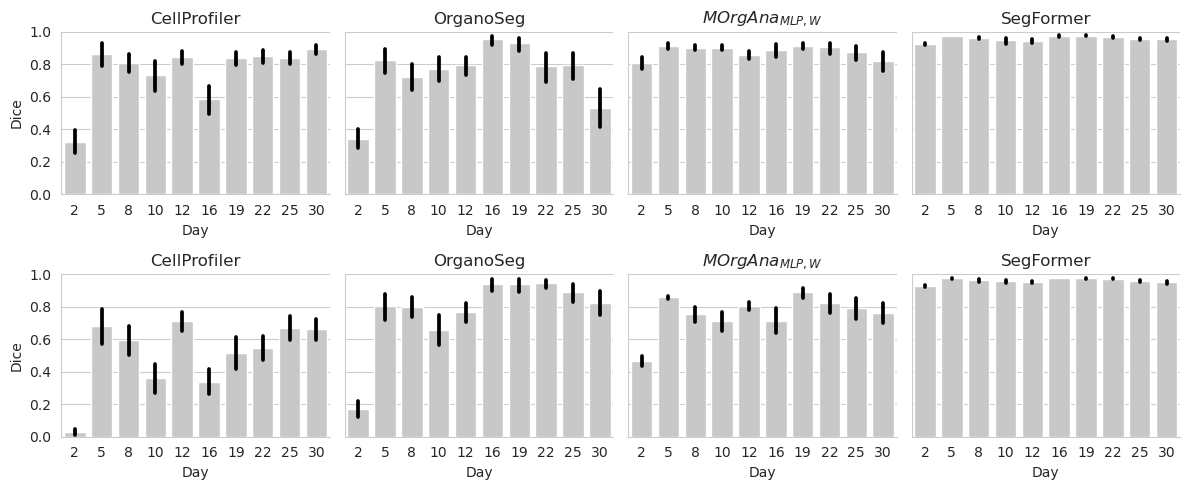

In [11]:
cols = ['pred_CellProfiler_dice', 'pred_OrganoSeg_dice', 'pred_MOrgAna_MLP_W_dice', 'pred_SegFormer_dice']
palette = ['#C8C8C8']*4

fig, axs = plt.subplots(2, len(cols), figsize=(12, 5), sharey=True)
palette2 = palette[:1] + palette[-1:]
for ilab, lab in enumerate(['LabA', 'LabB']):
    for i, col in enumerate(cols):
        ax = sns.barplot(data=df_pred[df_pred['Imaging']==lab], x='Day', y=col, orient='v', ax=axs[ilab, i], color=palette[i], errcolor='black')#, errorbar = ('ci', 95))
        # axs[i].set_ylabel('Dice')
    #     _ = ax.bar_label(ax.containers[0], fmt='%0.3f')
        axs[ilab, i].set_ylim((0.0, 1.0))
        axs[ilab, 0].set_title('CellProfiler')
        axs[ilab, 1].set_title('OrganoSeg')
        axs[ilab, 2].set_title(r'$MOrgAna_{MLP, W}$')
        axs[ilab, 3].set_title('SegFormer')
        axs[ilab, 0].set_ylabel('Dice')
        axs[ilab, 1].set_ylabel('')
        axs[ilab, 2].set_ylabel('')
        axs[ilab, 3].set_ylabel('')
# axs[2].set_ylabel('')
# axs[3].set_ylabel('')
sns.despine()
plt.tight_layout()
plt.savefig('plots/dice_scores_per_day.svg')


## Compare predictions per day

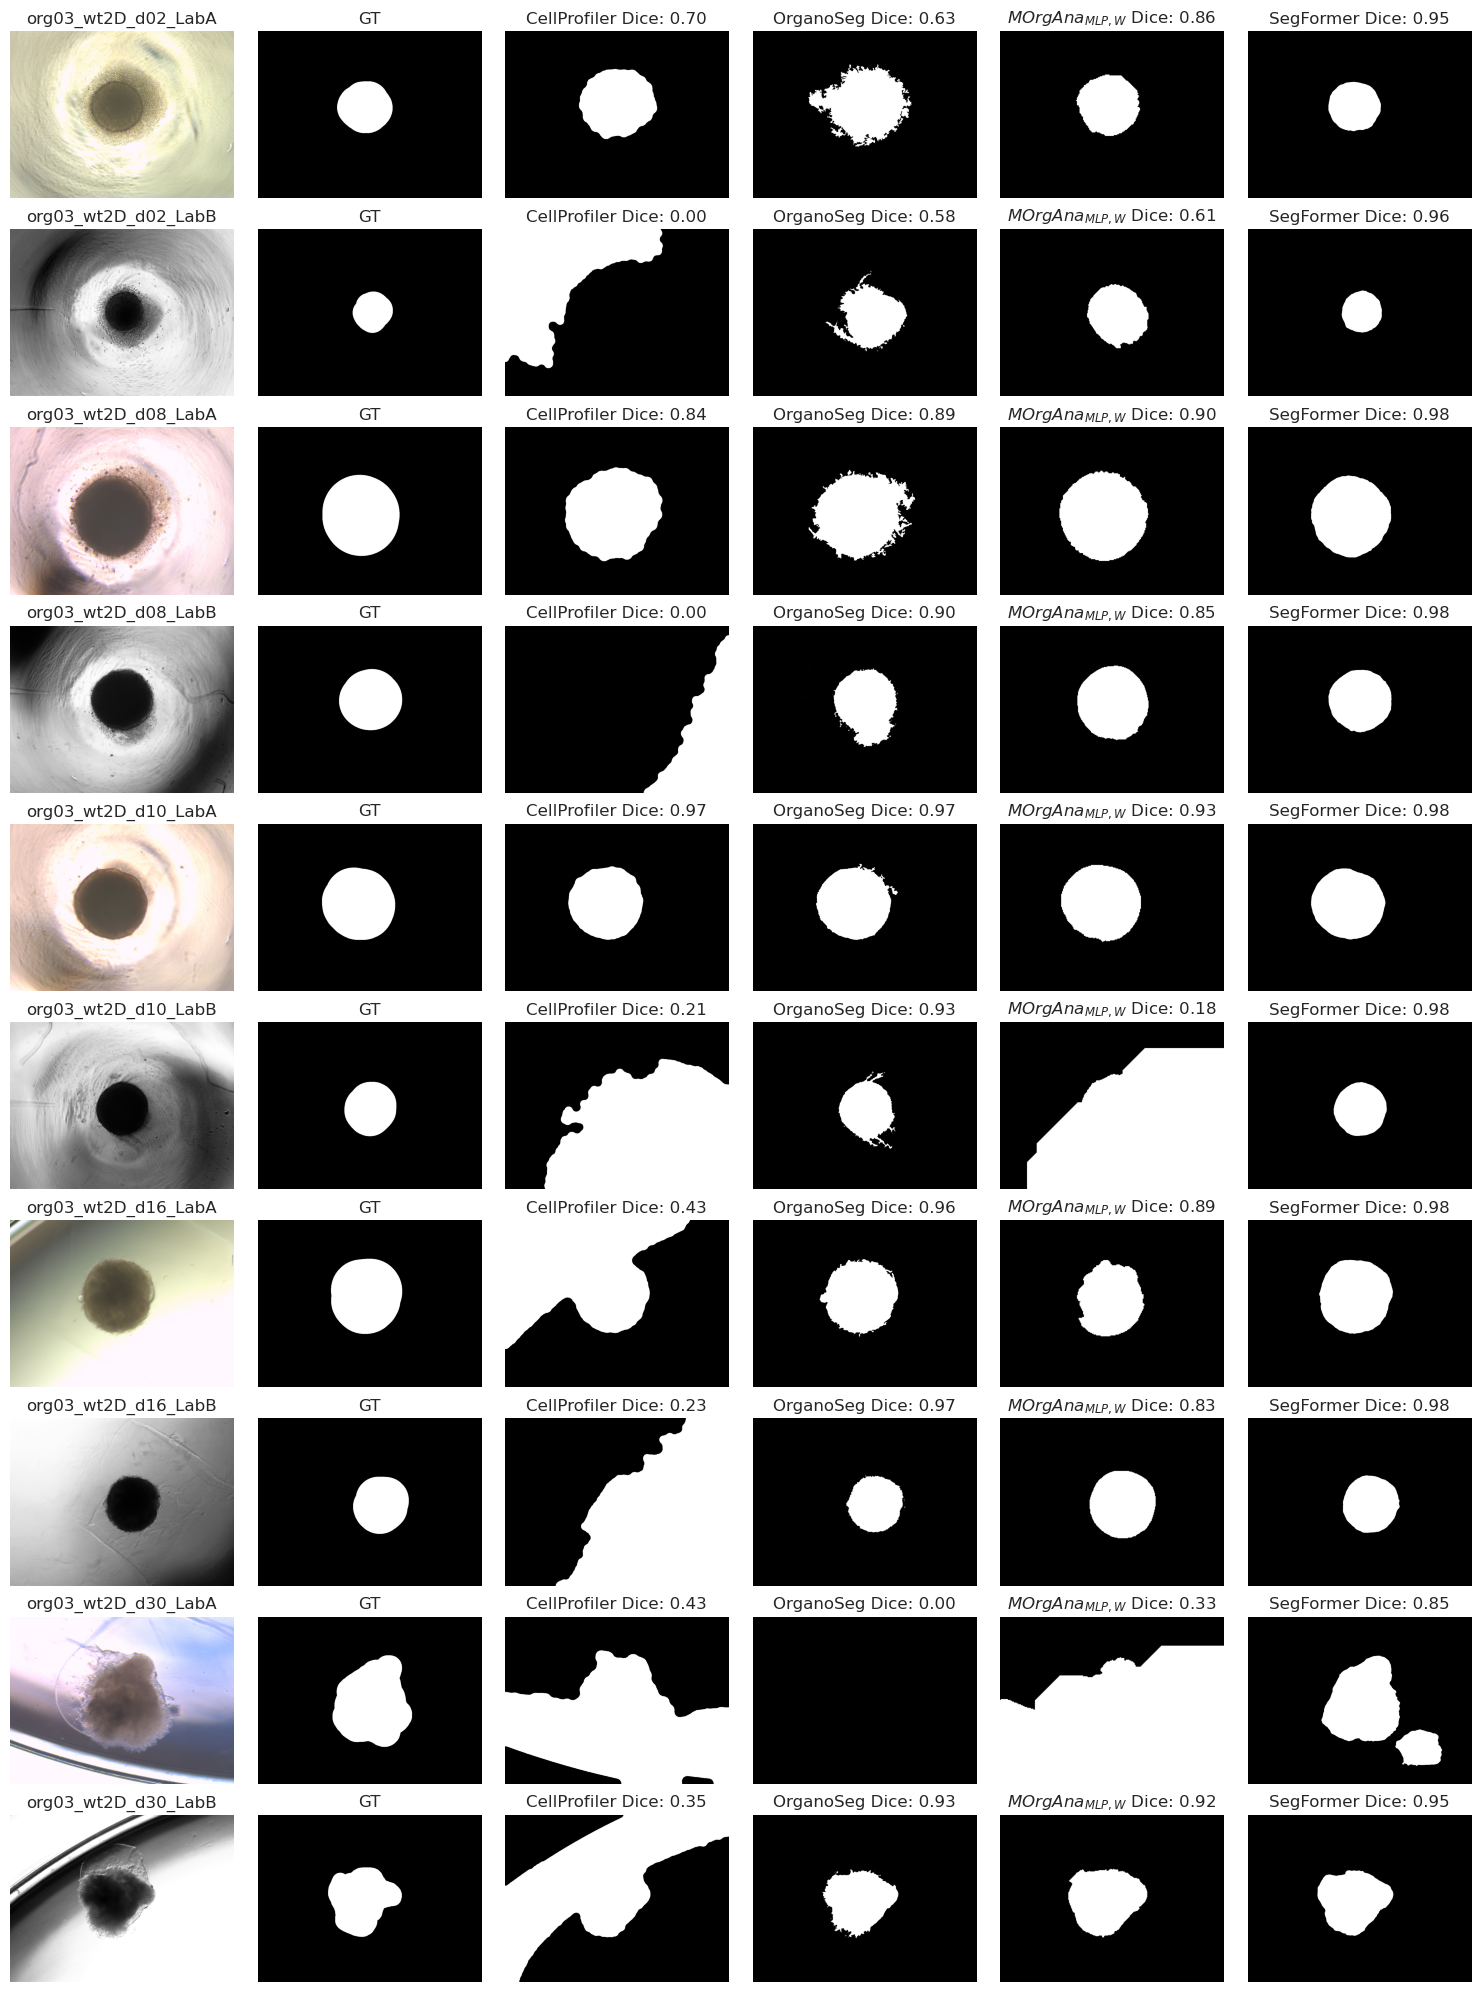

In [12]:
morg_col = 'MOrgAna_MLP_W'
morg_classifier = False
sns.set_style('white')
x = df_pred[(df_pred['org_id']==3) & (df_pred['Day'].isin([2, 8, 10, 16, 30]))].sort_values(['Day', 'Imaging']).reset_index(drop=True)
nr_rows, nr_cols = x.shape[0], 6
cell_width, cell_height = 2.5, 2
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*cell_width, nr_rows*cell_height))
for i, row in x.iterrows():
    img_id = row['img_id']
    axs[i, 0].imshow(Image.open(row['img']), cmap='viridis' if row['Imaging']=='LabA' else 'Greys_r')
    axs[i, 1].imshow(np.load(row['mask']), cmap='Greys_r')
    axs[i, 1].set_title('GT')
    
    axs[i, 2].imshow(Image.open(row['pred_CellProfiler']), cmap='Greys_r')
    axs[i, 2].set_title('CellProfiler'+f' Dice: {row["pred_CellProfiler_dice"]:.2f}')
    axs[i, 3].imshow(Image.open(row['pred_OrganoSeg']), cmap='Greys_r')
    axs[i, 3].set_title(f'OrganoSeg Dice: {row["pred_OrganoSeg_dice"]:.2f}')
    
    pred_morgana = np.asarray(Image.open(row[f'pred_{morg_col}']))
    axs[i, 4].imshow(pred_morgana, cmap='Greys_r')
    axs[i, 4].set_title(r'$MOrgAna_{MLP, W}$'+f' Dice: {row[f"pred_{morg_col}_dice"]:.2f}')
    axs[i, 5].imshow(np.load(row['pred_SegFormer']), cmap='Greys_r')
    axs[i, 5].set_title(f'SegFormer Dice: {row["pred_SegFormer_dice"]:.2f}')
    for j in range(6):
        axs[i, j].axis('off')
    axs[i, 0].set_title(img_id)
# axs[0, 2].set_title('MOrgAna')
# axs[0, 3].set_title('SegFormer')
plt.tight_layout()
plt.savefig('plots/qualitative_comparison_org3_days_2_8_10_16_30.svg')

# Comparison of growth monitoring

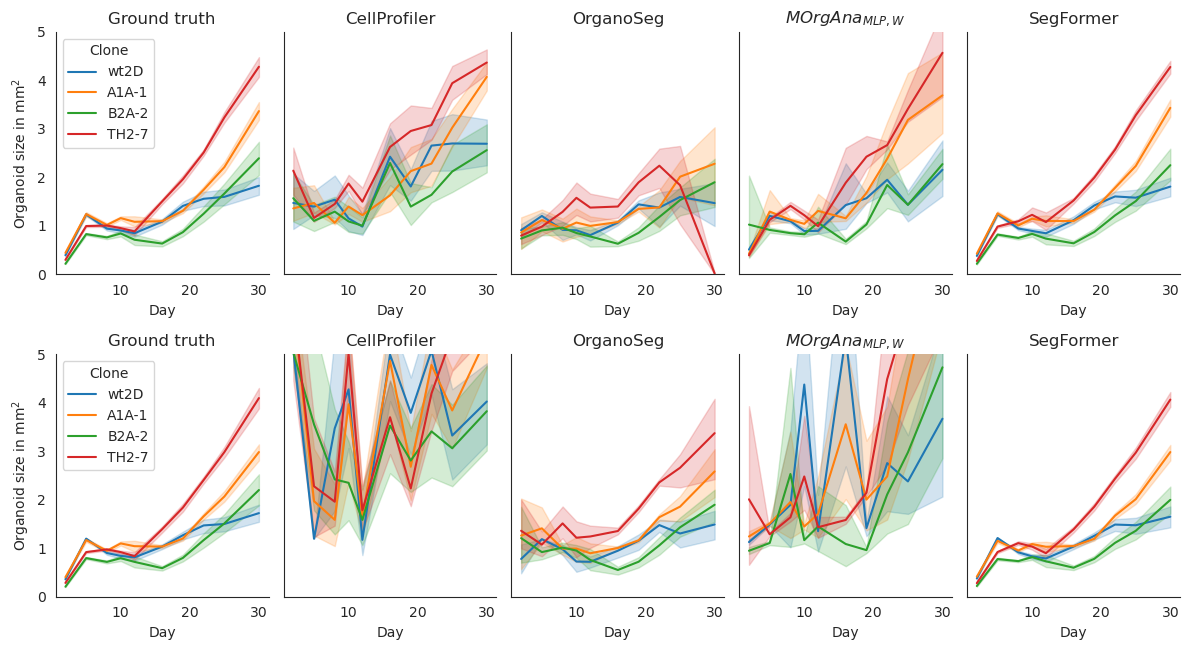

In [13]:
fig, axs = plt.subplots(2, 5, figsize=(12, 6.6), sharey=True)
# sns.set()

sns.set_style('whitegrid')
df_pred['org_size_mm2'] = df_pred['org_size_mikrometer2'] / 10**6

y_label = u'Organoid size in mm' +r'$^2$'
ylim = (0, 5)
titles = ['Ground truth', 'CellProfiler', 'OrganoSeg', r'$MOrgAna_{MLP, W}$', 'SegFormer']
for ilab, lab in enumerate(['LabA', 'LabB']):
    for isize_col, size_col in enumerate(['org_size_mm2', 'pred_CellProfiler_org_size_mm2', 'pred_OrganoSeg_org_size_mm2' , 'pred_MOrgAna_MLP_W_org_size_mm2', 'pred_SegFormer_org_size_mm2']):
        lineplot_org_sizes(df_pred[df_pred['Imaging']==lab], size_col=size_col,
                           filename='', 
                           y_label=y_label,
                           title=titles[isize_col],
                           day_col = 'Day', 
                           ax=axs[ilab, isize_col],
                           ylim=ylim,
                           hue = 'Clone')
for k in range(2):
    axs[k, 1].legend().set_visible(False)
    axs[k, 2].legend().set_visible(False)
    axs[k, 3].legend().set_visible(False)
    axs[k, 4].legend().set_visible(False)

plt.tight_layout()
plt.savefig('plots/org_sizes_both_labs_distinct_mm2.svg', dpi=500)


### Absolute

In [14]:
#absolute

df_pred_x = df_pred.copy()
df_pred_x = df_pred_x[df_pred_x['Imaging'] == 'LabA']

df_pred_x['CellProfiler_diff_org_size'] = df_pred_x['pred_CellProfiler_org_size_mum2'] - df_pred_x['org_size_mikrometer2']
df_pred_x['OrganoSeg_diff_org_size'] = df_pred_x['pred_OrganoSeg_org_size_mum2'] - df_pred_x['org_size_mikrometer2']
df_pred_x['MOrgAna_diff_org_size'] = df_pred_x['pred_MOrgAna_MLP_W_org_size_mum2'] - df_pred_x['org_size_mikrometer2']
df_pred_x['SegFormer_diff_org_size'] = df_pred_x['pred_SegFormer_org_size_mum2'] - df_pred_x['org_size_mikrometer2']


pd.set_option("display.precision", 0)
x = df_pred_x[['Day', 'CellProfiler_diff_org_size', 'OrganoSeg_diff_org_size', 'MOrgAna_diff_org_size', 'SegFormer_diff_org_size']].groupby('Day').aggregate('mean')
x

,CellProfiler_diff_org_size,OrganoSeg_diff_org_size,MOrgAna_diff_org_size,SegFormer_diff_org_size
Day,,,,
2,1297874.56,489610.66,250687.08,-12901.55
5,207585.33,-22706.92,59520.71,221.73
8,404867.07,95281.27,188017.62,17123.72
10,414076.43,136576.36,29604.04,60645.30
12,294134.34,109127.14,182146.15,58270.92
16,1164817.65,-36973.87,206814.06,13877.33
19,685424.67,-1896.64,287935.56,17594.71
22,648910.84,-220977.58,445151.96,28237.07
25,768932.58,-433490.32,188688.59,-26257.03


In [15]:
df_pred_x = df_pred.copy()
df_pred_x = df_pred_x[df_pred_x['Imaging'] == 'LabB']

df_pred_x['CellProfiler_diff_org_size'] = df_pred_x['pred_CellProfiler_org_size_mum2'] - df_pred_x['org_size_mikrometer2']
df_pred_x['OrganoSeg_diff_org_size'] = df_pred_x['pred_OrganoSeg_org_size_mum2'] - df_pred_x['org_size_mikrometer2']
df_pred_x['MOrgAna_diff_org_size'] = df_pred_x['pred_MOrgAna_MLP_W_org_size_mum2'] - df_pred_x['org_size_mikrometer2']
df_pred_x['SegFormer_diff_org_size'] = df_pred_x['pred_SegFormer_org_size_mum2'] - df_pred_x['org_size_mikrometer2']


pd.set_option("display.precision", 0)
x = df_pred_x[['Day', 'CellProfiler_diff_org_size', 'OrganoSeg_diff_org_size', 'MOrgAna_diff_org_size', 'SegFormer_diff_org_size']].groupby('Day').aggregate('mean')
x

,CellProfiler_diff_org_size,OrganoSeg_diff_org_size,MOrgAna_diff_org_size,SegFormer_diff_org_size
Day,,,,
2,5218580.94,839365.85,1019063.30,9666.81
5,1229864.79,127355.04,327160.38,-5343.45
8,1474561.54,238197.07,1119394.49,41077.74
10,2989812.85,57620.44,1454328.01,28117.74
12,694633.82,52155.77,634078.68,9186.67
16,3261957.28,-47412.99,1887958.18,4363.00
19,1602652.76,-62819.91,354102.28,-4402.50
22,2690623.99,-41482.25,1283917.80,770.07
25,1891114.80,-202161.08,1925529.69,-61049.36


### Relative

In [16]:
df_pred_x = df_pred.copy()
df_pred_x = df_pred_x[df_pred_x['Imaging'] == 'LabA']

df_pred_x['CellProfiler_diff_org_size'] = ((df_pred_x['pred_CellProfiler_org_size_mum2'] / df_pred_x['org_size_mikrometer2'])*100) - 100
df_pred_x['OrganoSeg_diff_org_size'] = ((df_pred_x['pred_OrganoSeg_org_size_mum2'] / df_pred_x['org_size_mikrometer2'])*100) - 100
df_pred_x['MOrgAna_diff_org_size'] = ((df_pred_x['pred_MOrgAna_MLP_W_org_size_mum2'] / df_pred_x['org_size_mikrometer2'])*100) - 100
df_pred_x['SegFormer_diff_org_size'] = ((df_pred_x['pred_SegFormer_org_size_mum2'] / df_pred_x['org_size_mikrometer2'])*100) - 100


pd.set_option("display.precision", 0)
x = df_pred_x[['Day', 'CellProfiler_diff_org_size', 'OrganoSeg_diff_org_size', 'MOrgAna_diff_org_size', 'SegFormer_diff_org_size']].groupby('Day').aggregate('mean')
x

,CellProfiler_diff_org_size,OrganoSeg_diff_org_size,MOrgAna_diff_org_size,SegFormer_diff_org_size
Day,,,,
2,435.95,163.22,117.04,-3.57
5,20.73,-0.74,6.82,-0.12
8,46.69,11.22,20.27,1.80
10,43.97,16.37,4.44,7.26
12,32.13,10.09,30.22,6.25
16,133.30,-2.83,18.05,1.33
19,52.36,0.18,21.09,1.32
22,45.45,-13.02,41.96,1.89
25,40.55,-15.38,7.24,-1.84


In [17]:
df_pred_x = df_pred.copy()
df_pred_x = df_pred_x[df_pred_x['Imaging'] == 'LabB']

df_pred_x['CellProfiler_diff_org_size'] = ((df_pred_x['pred_CellProfiler_org_size_mum2'] / df_pred_x['org_size_mikrometer2'])*100) - 100
df_pred_x['OrganoSeg_diff_org_size'] = ((df_pred_x['pred_OrganoSeg_org_size_mum2'] / df_pred_x['org_size_mikrometer2'])*100) - 100
df_pred_x['MOrgAna_diff_org_size'] = ((df_pred_x['pred_MOrgAna_MLP_W_org_size_mum2'] / df_pred_x['org_size_mikrometer2'])*100) - 100
df_pred_x['SegFormer_diff_org_size'] = ((df_pred_x['pred_SegFormer_org_size_mum2'] / df_pred_x['org_size_mikrometer2'])*100) - 100


pd.set_option("display.precision", 0)
x = df_pred_x[['Day', 'CellProfiler_diff_org_size', 'OrganoSeg_diff_org_size', 'MOrgAna_diff_org_size', 'SegFormer_diff_org_size']].groupby('Day').aggregate('mean')
x

,CellProfiler_diff_org_size,OrganoSeg_diff_org_size,MOrgAna_diff_org_size,SegFormer_diff_org_size
Day,,,,
2,1768.40,302.82,351.17,3.46
5,141.72,14.27,33.35,-0.63
8,173.31,28.25,137.22,4.58
10,333.80,7.64,171.88,3.62
12,71.93,6.18,82.35,1.48
16,361.57,-5.39,194.28,0.67
19,153.76,-5.69,28.71,-0.50
22,191.84,-2.63,79.96,-0.04
25,103.43,-10.51,100.67,-3.75


# Similarity of clones

In [36]:
def get_normalized_organoid_features(df):
    # Initialize the feature extractor
    extractor = featureextractor.RadiomicsFeatureExtractor()
    extractor.disableAllFeatures()
    extractor.enableFeatureClassByName('shape2D')
    
    radiomics_df = pd.DataFrame()
    
    radiomics_data = []
    for idx, row in df.iterrows():
        img = sitk.GetImageFromArray(np.asarray(Image.open(row['img']).convert('L')))
        mask_np = np.load(row['mask']).astype('int')
        if len(np.unique(mask_np)) == 1:
            continue
        mask = sitk.GetImageFromArray(mask_np)
        
        f= extractor.execute(img, mask)
        f = {k: v for k, v in f.items() if not 'diagnostics' in k}
        f['img_id'] = row['img_id']
        
        radiomics_data.append(f)
    
    # Create the radiomics DataFrame
    radiomics_df = pd.DataFrame(radiomics_data)

    img_ids = radiomics_df[['img_id']]
    org_features = radiomics_df.loc[:, radiomics_df.columns != 'img_id']
    org_features = (org_features - org_features.mean()) / org_features.std()
    
    radiomics_df = pd.concat([org_features, img_ids], axis=1)
    return radiomics_df

def get_pca_results(df, radiomics_df):

    # Extract the sample IDs
    sample_ids = radiomics_df['img_id']
    
    # Perform PCA on the feature columns
    n_components = 2  # Number of components to keep (in this case, 2 for the first two PCs)
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(radiomics_df.iloc[:, :-1])  # Assuming feature columns start from index 2
    
    # Create new column names for the first two principal components
    pc_columns = ['PC1', 'PC2']
    
    # Create a new DataFrame with the sample IDs and the first two principal components
    pca_df = pd.DataFrame(data=principal_components, columns=pc_columns)
    
    # Concatenate the sample IDs and the PCA results
    pca_df = pd.concat([sample_ids, pca_df], axis=1)
    pca_df = pca_df.merge(df[['img_id', 'Clone', 'Day']], on='img_id')
    return pca_df
    
def plot_daywise_clone_similarity(pca_df):
    days = pca_df['Day'].unique().tolist()
    pca_df['Day12_specific'] = pca_df.apply(lambda row: '_'.join(row['img_id'].split('_')[-2:]) if row['Day']==12 else np.nan, axis=1)
    pca_df = pca_df[pca_df['Day12_specific'].isin([np.nan, 'after_embedding'])]
    
    nr_rows = len(days)
    fig, axs = plt.subplots(2, 5, figsize=(15, 6))#, sharey=True, sharex=True)
    axs = axs.ravel()
    for i, d in enumerate(days):
        sns.scatterplot(data=pca_df[(pca_df['Day']==d)], x='PC1', y='PC2', hue='Clone', ax=axs[i])
        axs[i].legend(bbox_to_anchor=(1.1, 1.05))
        axs[i].set_title(f'Day {d}')
        axs[i].grid(False)
    for i, ax in enumerate(axs.flat[0:-1]):
        ax.get_legend().remove()
    plt.tight_layout()
    plt.savefig('plots/clone_similarity.svg')



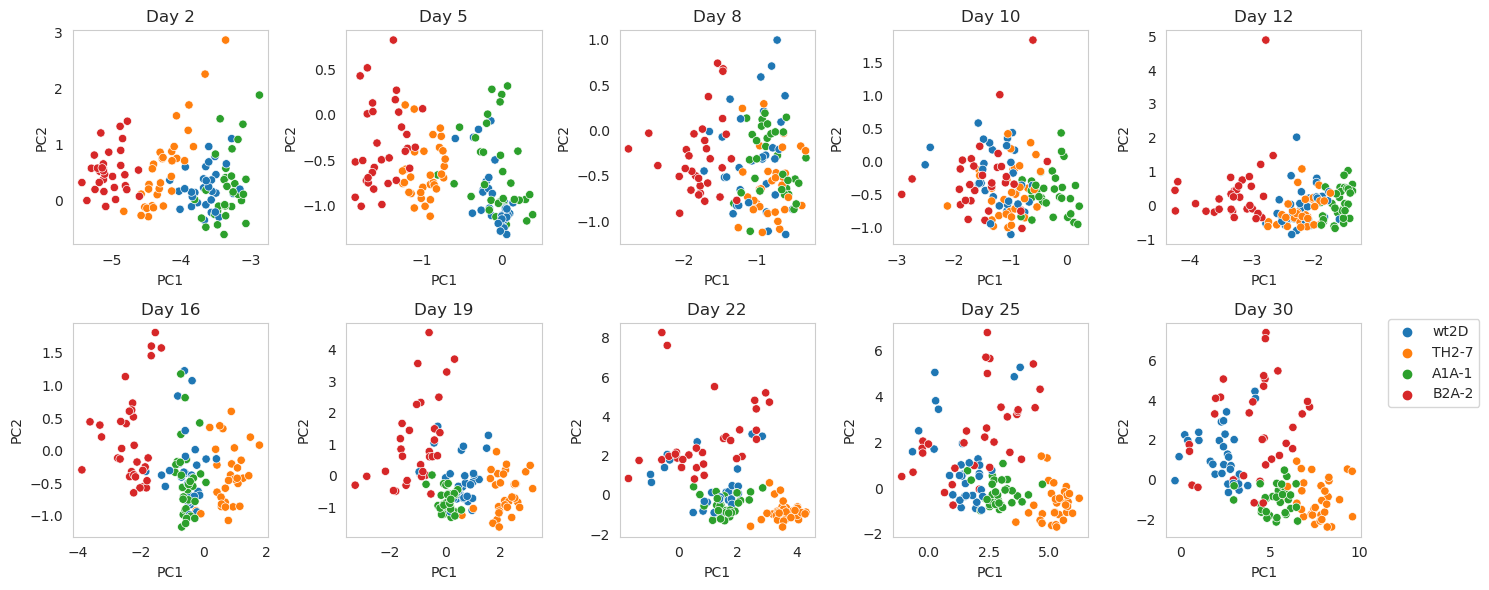

In [38]:
organoid_features = get_normalized_organoid_features(df)
pca_df = get_pca_results(df, organoid_features)
plot_daywise_clone_similarity(pca_df)

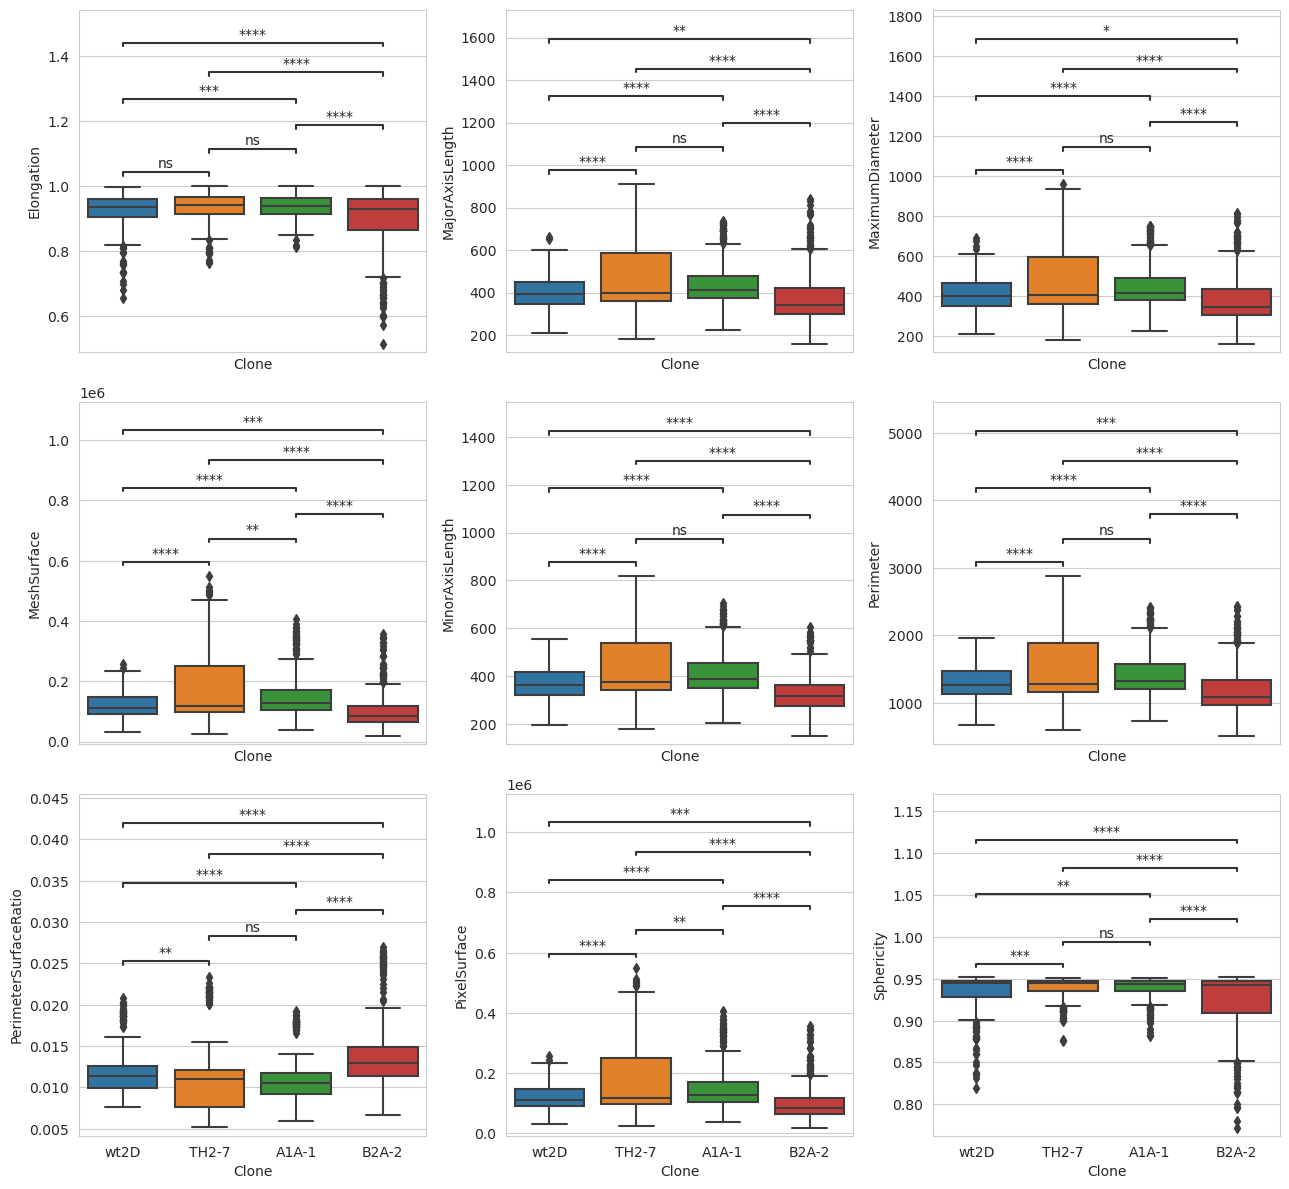

In [20]:
# x = organoid_features.merge(df[['img_id', 'Clone']])
# features = ['original_shape2D_Elongation', 'original_shape2D_MajorAxisLength',
#        'original_shape2D_MaximumDiameter', 'original_shape2D_MeshSurface',
#        'original_shape2D_MinorAxisLength', 'original_shape2D_Perimeter',
#        'original_shape2D_PerimeterSurfaceRatio',
#        'original_shape2D_PixelSurface', 'original_shape2D_Sphericity']
# nr_rows = len(features)
# fig, axs = plt.subplots(3, 3, figsize=(13, 12), sharex=True)
# axs = axs.ravel()

# for i, f in enumerate(features):
#     x[f] = x[f].astype('float')
#     sns.boxplot(data=x, x='Clone', y=f, ax=axs[i])
#     axs[i].set_ylabel(f.replace('original_shape2D_', ''))

#     statannot.add_stat_annotation(
#         ax=axs[i],
#         data=x,
#         x='Clone',
#         y=f,
#         box_pairs=[('wt2D', "TH2-7"),
#                   ('wt2D', "A1A-1"),
#                   ('wt2D', "B2A-2"),
#                   ('TH2-7', "A1A-1"),
#                   ('TH2-7', "B2A-2"),
#                   ('A1A-1', "B2A-2")],
#         test="t-test_ind",
#         text_format="star",
#         loc="inside",
#         verbose = 0
#     )
    
# plt.tight_layout()